# IMPORT SECTION

In [ ]:
!pip install --upgrade music21==6.7.1
from music21 import converter, instrument, note, chord, stream
import os
from tqdm import tqdm
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Dropout
%load_ext tensorboard 
from tensorboard import notebook
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau

     |████████████████████████████████| 19.2 MB 1.4 MB/s 
  Created wheel for music21: filename=music21-6.7.1-py3-none-any.whl size=21941721 sha256=9e263e65d6077dae60518bdf57a4e6b13454c12505375b82f0aac460e76717c4
  Stored in directory: /root/.cache/pip/wheels/72/44/61/90e4e65262ca1b4d9f707527b540729ce3f64e00fc6b38d54c
Successfully built music21
  Attempting uninstall: music21
    Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=False)

MIDI_PATH="/content/drive/My Drive/MLFolder/Onlab/MIDI_Iron_Maiden/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Sun Nov  7 10:02:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# UTILITY FUNCTIONS SECTION

In [ ]:
def most_frequent(paramlist): 
    #https://www.geeksforgeeks.org/python-find-most-frequent-element-in-a-list/
    counter = 0
    num = paramlist[0] 
      
    for i in paramlist: 
        curr_frequency = paramlist.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def create_mapper(chords):
    pitchnames = sorted(set(str(item) for item in chords))
    mapper = dict((note, number) for number, note in enumerate(pitchnames))

    return mapper

def encode_using_mapper(chords, mapper):
    encodedsong=[]
    for c in chords:
        encodedsong.append(mapper[str(c)])

    return encodedsong


def decode_chords_using_mapper(numbers, mapper):
    outputnotes = []
    for number in numbers:
        outputnotes.append(chord_from_string(get_notes_from_chord(get_key_from_value(number, mapper))))

    return outputnotes

def combine_chords_with_durations(chords, durations):
    combined = []

    for i, j in zip(chords, durations):
        i = get_notes_from_chord(str(i))
        j = get_number_from_duration(str(j))
        combined.append(i + ';' + j)

    return combined

def make_slices(data, slice_length):
    for song in tqdm(data):
        if len(song) > slice_length:

            input = []
            output = []
            slice = []

            for idx, number in enumerate(song):
                if idx < slice_length:
                    slice.append(number)

            input.append(slice.copy())
            output.append(song[slice_length])

            # Sliding window
            for idx, number in enumerate(song):
                if idx >= slice_length and (idx + 1) < len(song):
                    slice.pop(0)
                    slice.append(number)
                    input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
                    output.append(song[idx + 1])

    return input, output

def parse_everything_together(data, slice_length):

    notes=[]
    input=[]
    output=[]
    slice = []

    for song in tqdm(data):
        for number in song:
            notes.append(number)
    
    for idx, note in tqdm(enumerate(notes)):
        if idx < slice_length:
            slice.append(number)

    input.append(slice.copy())
    output.append(notes[slice_length])

    # Sliding window
    for idx, number in tqdm(enumerate(notes)):
        if idx >= slice_length and (idx + 1) < len(notes):
            slice.pop(0)
            slice.append(number)
            input.append(slice.copy())  # Copy is necessary, because of how pointers and lists work in Python
            output.append(notes[idx + 1])
        
    return input, output

def get_key_from_value(value, dict):
    return list(dict.keys())[list(dict.values()).index(value)]

def get_notes_from_chord(chord):
    if chord.startswith("<music21.chord.Chord "):
        chord = chord[len("<music21.chord.Chord "):]
    if chord.endswith(">"):
        chord = chord[:-1]
    chord = chord.replace(" ", ",")
    return chord

def get_number_from_duration(duration):
    if duration.startswith("<music21.duration.Duration "):
        duration = duration[len("<music21.duration.Duration "):]
    if duration.endswith(">"):
        duration = duration[:-1]
    duration = duration.replace(" ", ",")
    return duration

def chord_from_string(chordstring):
    notes = chordstring.split(";")
    return chord.Chord(notes)


def convert_to_float(frac_str):
    #From: https://stackoverflow.com/questions/1806278/convert-fraction-to-float
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac

#Source: https://github.com/alexissa32/DataScienceMusic
def create_midi_without_chords(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    First step:
    Only notes, no chords
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_without_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    '''
    Second step:
    Chords and notes
    Static 4/4 beat
    Rests
    '''
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_durations(prediction_output, output_durations, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        duration = get_number_from_duration(output_durations[i])
        # pattern is a chord
        if ('chord' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a rest
        elif('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def create_midi_with_embedded_durations(prediction_output, target_instrument = instrument.Piano(), filename = 'test_output.mid'):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for i in range(len(prediction_output)):
        pattern = prediction_output[i]
        splitpattern = pattern.split(";")
        pattern = splitpattern[0]

        duration = get_number_from_duration(splitpattern[1])
        # pattern is a rest
        if('rest' in pattern):
            new_rest = note.Rest(pattern)
            new_rest.offset = offset
            new_rest.storedInstrument = target_instrument #???
            output_notes.append(new_rest)
        # pattern is a chord
        elif (',' in pattern):
            notes = []
            pattern = get_notes_from_chord(pattern)
            patternpitches = pattern.split(',')
            for current_note in patternpitches:
                new_note = note.Note(current_note)
                new_note.storedInstrument = target_instrument
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = target_instrument
            output_notes.append(new_note)
        # increase offset each iteration so that notes do not stack
        offset += convert_to_float(duration)

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=filename)

def parse_midi_notes_and_durations():
    midiparts = []

    for file in tqdm(os.listdir(path)):
        midi = converter.parse(os.path.join(path, file))

        for part in midi.parts:
            chords=[]
            durations=[]
            for element in part.notesAndRests:
                if isinstance(element, note.Note):
                    chords.append(chord.Chord([element]))
                    durations.append(element.duration)
                elif isinstance(element, chord.Chord):
                    chords.append(element)
                    durations.append(element.duration)
                elif isinstance(element, note.Rest):
                    chords.append(element)
                    durations.append(element.duration)

            if len(chords) > 0:
                midiparts.append(MidiPart(file, part.partName, chords, durations))
            else:
                for voice in part.voices:
                    chords=[]
                    durations=[]
                    for element in voice.notesAndRests:
                        if isinstance(element, note.Note):
                            chords.append(chord.Chord([element]))
                            durations.append(element.duration)
                        elif isinstance(element, chord.Chord):
                            chords.append(element)
                            durations.append(element.duration)
                        elif isinstance(element, note.Rest):
                            chords.append(element)
                            durations.append(element.duration)

                    midiparts.append(MidiPart(file, part.partName, chords, durations))

    return midiparts

# PREPROCESSING SECTION


In [ ]:
class MidiPart:
    def __init__(self, song, instrument, chords, durations):
        self.song = song
        self.instrument = instrument
        self.chords = chords
        self.durations = durations


path = MIDI_PATH

IRON_MAIDEN_INSTRUMENTS = ['Acoustic Guitar', 'Viola', 'Electric Bass', 'Brass', 'Sampler', 'Electric Guitar', 'Piano', 'StringInstrument']

SLICE_LEN = 20

In [ ]:
midiparts = parse_midi_notes_and_durations()

100%|██████████| 93/93 [13:50<00:00,  8.93s/it]


In [ ]:
allchords = []
alldurations = []

TARGET_INSTRUMENT = 'Electric Guitar'
for i in midiparts:
    if i.instrument == TARGET_INSTRUMENT:
        if len(i.chords)>0 :
            allchords.append(i.chords)
            alldurations.append(i.durations)

In [ ]:
#RUN THIS CELL IF YOU WANT NOTES TO HAVE DURATIONS

assert(len(allchords) == len(alldurations))

combined = []
for i in range(len(allchords)):
    combined.append(combine_chords_with_durations(allchords[i], alldurations[i]))

mapperdata = []

for i in combined:
    for j in i:
        mapperdata.append(j)

mapper = create_mapper(mapperdata)

encoded_data = []

for c in combined:
    encoded = encode_using_mapper(c, mapper)
    encoded_data.append(encoded)

restkeysvalues = []
for j in mapper.keys():
    if ( 'rest' in j):
        restkeysvalues.append(mapper[j])

cleared_encoded_data=[]

for i in range(len(encoded_data)):
    if most_frequent(encoded_data[i]) not in restkeysvalues:
        cleared_encoded_data.append(encoded_data[i])
    else:
        pass

In [ ]:
#Creating the input data

input, output = parse_everything_together(cleared_encoded_data, SLICE_LEN)

100%|██████████| 408/408 [00:00<00:00, 21330.96it/s]
240815it [00:00, 2870581.21it/s]
240815it [00:00, 730428.10it/s]


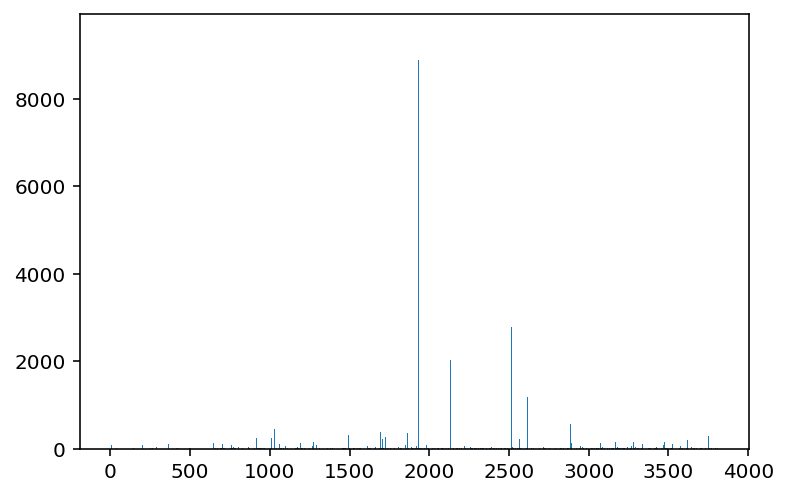

[1963, 2553, 1966, 2490, 1626, 1238, 1235, 2952, 1248, 2285, 3271, 3709, 902, 1041, 1033, 1752, 804, 927, 1949, 236, 2889, 956, 1835, 1419, 3809, 1239, 2636, 2424, 1303, 812, 821, 2787, 3591, 256, 99, 302, 40, 95, 518, 162, 574, 2900, 97, 430, 167, 2831, 2850, 2164, 2177, 1352, 520, 369, 1769, 594, 600, 406, 2816, 545, 549, 50, 3777, 251, 1814, 2823, 1398, 3130, 3121, 2235, 2238, 929, 2829, 2833, 2847, 2812, 1381, 3700, 3701, 3037, 3038, 2038, 873, 874, 3702, 2458, 1873, 623, 1579, 1878, 94, 3386, 2231, 67, 1032, 3218, 1807, 1654, 3528, 1337, 1782, 253, 1131, 3290, 3277, 3732, 2523, 349, 593, 404, 146, 932, 378, 111, 417, 228, 537, 13, 39, 1747, 225, 536, 171, 415, 148, 2535, 1278, 361, 247, 1121, 2922, 2361, 1508, 1308, 3769, 2897, 1823, 959, 2898, 2646, 867, 3680, 2007, 3284, 909, 1815, 2226, 1078, 1065, 3310, 968, 1524, 3082, 561, 2905, 2522, 1401, 1385, 1387, 2895, 1388, 1206, 2570, 2121, 724, 307, 2394, 110, 125, 3245, 3681, 1023, 3540, 693, 779, 767, 1656, 1497, 1493, 1739, 2064,

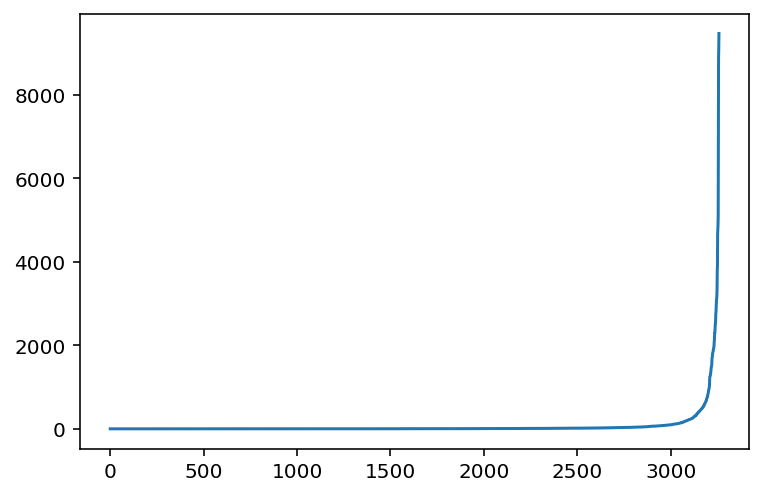

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

outputcnt = Counter(output)
plt.bar(outputcnt.keys(), outputcnt.values())
plt.show()

function_like_array=[]
for val in outputcnt.values():
    function_like_array.append(val)

function_like_array.sort()
plt.plot(function_like_array)



outliers = []
OUTLIER_CONSTANT = 40

for i in outputcnt.keys():
    if outputcnt[i] < OUTLIER_CONSTANT:
        outliers.append(i)

print(outliers)
print(len(outliers))

In [ ]:
#Because I don't want to mess up my inputs and outputs, I test their lengths before and after the outlier filtering.
assert(len(input) == len(output))

newinput=[]
newoutput=[]

for i in range(len(output)):
    if(output[i] not in outliers):
        newinput.append(input[i])
        newoutput.append(output[i])

input = newinput
output = newoutput

assert(len(input) == len(output))

In [ ]:
#However, this outlier filtering made things complicated. Now I have to make a new mapper, so that i won't end up with output classes containing 0 elements.

mapper_list = [] #Idx of the mapper list is the new value, the element is the old value.
new_output_elements = set(output)

for i in new_output_elements:
    mapper_list.append(i)

newoutput = []

for i in output:
    newoutput.append(mapper_list.index(i))

output = newoutput

In [ ]:
#Reshaping the input data to be compatible with LSTMs and normalizing it in the hope of better learning.

input = np.reshape(np.asarray(input), (len(input), SLICE_LEN, 1))
#output = to_categorical(output)

#input=np.asarray(input) / float(len(mapper))
output=np.asarray(output)

In [ ]:
SEED = 54
#np.random.seed(SEED)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.01, random_state=SEED)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=SEED)

startidx = np.random.randint(0, len(X_test)-1)
starting_slice = X_test[startidx]

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)
print(startidx)
print(starting_slice)

(176576, 20, 1) (44144, 20, 1) (2230, 20, 1) (176576,) (44144,) (2230,)
1887
[[1700]
 [1936]
 [1934]
 [1030]
 [1030]
 [ 789]
 [3209]
 [1602]
 [1936]
 [1934]
 [1030]
 [1030]
 [ 789]
 [3209]
 [1602]
 [1936]
 [1934]
 [1030]
 [1030]
 [ 789]]


# MODEL TRAINING SECTION

In [ ]:
from tensorflow.keras.utils import Sequence

# DATA GENERATOR
NUM_CLASSES = to_categorical(Y_train).shape[1]
SLICE_SIZE = SLICE_LEN

class MyDatagen(Sequence):
  def __init__(self, list_IDs, batch_size=16, dim=(SLICE_SIZE), shuffle=True, validation=False):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.validation=validation
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
      #Updates indexes after each epoch
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    #Generates data containing batch_size samples
    if self.validation:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = X_val[ID]

        y[i] = to_categorical(Y_val[ID], num_classes=NUM_CLASSES)

      return X, y
    else:
      X = np.empty((self.batch_size, self.dim, 1))
      y = np.empty((self.batch_size, NUM_CLASSES))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = X_train[ID]

        y[i] = to_categorical(Y_train[ID], num_classes=NUM_CLASSES)

      return X, y

In [ ]:
MODEL_NAME = "Attention_guitar_2"

MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves/"

TBPATH = "/content/tblogs/"+MODEL_NAME

In [ ]:
#Before creating the neural network, I define some important callbacks

tb = TensorBoard(log_dir = TBPATH, write_images=True, histogram_freq=1)

plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00005, verbose=1)

es = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True, verbose=1)

callbacks = [plateau, es, tb]

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow as tf
import math as m

class DynamicPositionEmbedding(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        embedding_dim=256
        max_seq=2048
        embed_sinusoid_list = np.array([[
            [
                m.sin(
                    pos * m.exp(-m.log(10000) * i/embedding_dim) *
                    m.exp(m.log(10000)/embedding_dim * (i % 2)) + 0.5 * m.pi * (i % 2)
                )
                for i in range(embedding_dim)
            ]
            for pos in range(max_seq)
        ]])
        self.positional_embedding = tf.constant(embed_sinusoid_list, dtype=tf.float32)

    def call(self, inputs, **kwargs):
        return tf.add(inputs, self.positional_embedding[:,:inputs.shape[1],:])

In [ ]:
#I create the neural network model here.
from tensorflow.keras.layers import MultiHeadAttention, Attention
from tensorflow.keras.layers import Embedding, Reshape, Dropout
from tensorflow.keras.layers import Input, LayerNormalization
from tensorflow.keras.models import Model


input_layer = Input(shape=(SLICE_LEN,1))
x = Embedding(len(mapper), 256, input_length=SLICE_LEN)(input_layer)
x = Reshape((SLICE_LEN,256))(x)
x = DynamicPositionEmbedding()(x)
x = MultiHeadAttention(num_heads=16, key_dim=10, dropout=0.1)(x,x)
x = Flatten()(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(input_layer, output)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

training_gen=MyDatagen(range(X_train.shape[0]), dim = SLICE_LEN, batch_size=16)
val_gen=MyDatagen(range(X_val.shape[0]), dim = SLICE_LEN, batch_size=16, validation=True)

model.fit(training_gen, epochs=10000, validation_data=val_gen, callbacks=callbacks)

model.evaluate(X_test, to_categorical(Y_test, num_classes=NUM_CLASSES))

model.save(MODEL_SAVE_PATH + MODEL_NAME + ".h5")

In [ ]:
from tensorflow.keras.layers import MultiHeadAttention, Attention
from tensorflow.keras.layers import Embedding, Reshape, LSTM
from tensorflow.keras.layers import Input, LayerNormalization
from tensorflow.keras.models import Model

#LSTM + Attention

input_layer = Input(shape=(SLICE_LEN,1))
x = LSTM(512, return_sequences=True)(input_layer)
x = LSTM(256, return_sequences=True)(x)
attn_out = MultiHeadAttention(num_heads=16, key_dim=10, dropout=0.1)(x,x)
x = Flatten()(attn_out)
output = Dense(NUM_CLASSES, activation='softmax')(x)
model2 = Model(input_layer, output)

model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


training_gen=MyDatagen(range(X_train.shape[0]), dim = 20, batch_size=16)
val_gen=MyDatagen(range(X_val.shape[0]), dim = 20, batch_size=16, validation=True)

model2.fit(X_train/len(mapper), to_categorical(Y_train), epochs=10000, validation_data=(X_val/len(mapper), to_categorical(Y_val)), callbacks=callbacks)

model2.evaluate(X_test/len(mapper), to_categorical(Y_test))

Epoch 1/10000
5518/5518 [==============================] - 60s 10ms/step - loss: 4.4852 - accuracy: 0.1233 - val_loss: 3.7217 - val_accuracy: 0.2400
Epoch 2/10000
5518/5518 [==============================] - 56s 10ms/step - loss: 3.0236 - accuracy: 0.3710 - val_loss: 2.5033 - val_accuracy: 0.4701
Epoch 3/10000
5518/5518 [==============================] - 55s 10ms/step - loss: 2.0721 - accuracy: 0.5476 - val_loss: 2.0015 - val_accuracy: 0.5780
Epoch 4/10000
5518/5518 [==============================] - 55s 10ms/step - loss: 1.5932 - accuracy: 0.6360 - val_loss: 1.7399 - val_accuracy: 0.6411
Epoch 5/10000
5518/5518 [==============================] - 55s 10ms/step - loss: 1.3030 - accuracy: 0.6933 - val_loss: 1.6578 - val_accuracy: 0.6687
Epoch 6/10000
5518/5518 [==============================] - 55s 10ms/step - loss: 1.1076 - accuracy: 0.7338 - val_loss: 1.5980 - val_accuracy: 0.6870
Epoch 7/10000
5518/5518 [==============================] - 55s 10ms/step - loss: 0.9651 - accuracy: 0.7647

[1.5110688209533691, 0.778923749923706]